In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy import stats #wilcoxon signed rank test, pearson corr
import similaritymeasures #similarity measures for curves
import pingouin as pg #cronbach alpha
from statsmodels.stats.proportion import proportions_ztest # two proportions z test
import re #wordcloud string processing
from wordcloud import WordCloud #wordcloud
from deep_translator import GoogleTranslator #wordclouds translate

<h2> Read data</h2>

In [21]:
#sensordata
dfs = pd.read_csv('data_share/dfs.csv', parse_dates=True, index_col='Timestamp')
#surveydata
df = pd.read_csv('data_share/df.csv', parse_dates=True, index_col='Timestamp')
#police intervention data
dfpol = pd.read_csv('data_share/dfpol.csv', parse_dates=True, index_col='Timestamp')
#first aid data
dfrk = pd.read_csv('data_share/dfrk.csv', parse_dates=True, index_col='Timestamp')

<h2>Preprocessing</h2>

Survey data

In [22]:
#split up by location
vlasmarkt = df[df['location']=='Vlasmarkt']
belfortstraat = df.loc[df['location']=='Belfortstraat']
stadshal = df.loc[df['location']=='Stadshal']

#median per hour
vlasmarktH = df.loc[df['location']=='Vlasmarkt'].resample('H').median()
belfortstraatH = df.loc[df['location']=='Belfortstraat'].resample('H').median()
stadshalH = df.loc[df['location']=='Stadshal'].resample('H').median()

#rolling mean over 4 hours: human
stadshaltrend = stadshal['human'].rolling('4H', center=True, min_periods=20).mean().to_frame()
vlasmarkttrend = vlasmarkt['human'].rolling('4H', center=True, min_periods=20).mean().to_frame()
belforttrend = belfortstraat['human'].rolling('4H', center=True, min_periods=5).mean().to_frame()
#rolling mean over 4 hours: pleasure
stadshaltrendP = stadshal['pleasure'].rolling('4H', center=True, min_periods=20).mean().to_frame()
vlasmarkttrendP = vlasmarkt['pleasure'].rolling('4H', center=True, min_periods=20).mean().to_frame()
belforttrendP = belfortstraat['pleasure'].rolling('4H', center=True, min_periods=5).mean().to_frame()
#rolling mean over 4 hours: space
stadshaltrendS = stadshal['spatial'].rolling('4H', center=True, min_periods=20).mean().to_frame()
vlasmarkttrendS = vlasmarkt['spatial'].rolling('4H', center=True, min_periods=20).mean().to_frame()
belforttrendS = belfortstraat['spatial'].rolling('4H', center=True, min_periods=5).mean().to_frame()
#rolling mean over 4 hours: space inverse
stadshaltrendSI = stadshal['spatialI'].rolling('4H', center=True, min_periods=20).mean().to_frame()
vlasmarkttrendSI = vlasmarkt['spatialI'].rolling('4H', center=True, min_periods=20).mean().to_frame()
belforttrendSI = belfortstraat['spatialI'].rolling('4H', center=True, min_periods=5).mean().to_frame()

#rolling mean resampled per hour
vlasmarkttrendSh = vlasmarkttrendS.resample('H').mean()
vlasmarkttrendSIh = vlasmarkttrendSI.resample('H').mean()
vlasmarkttrendh = vlasmarkttrend.resample('H').mean()
vlasmarkttrendPh = vlasmarkttrendP.resample('H').mean()
stadshaltrendSh = stadshaltrendS.resample('H').mean()
stadshaltrendSIh = stadshaltrendSI.resample('H').mean()
stadshaltrendh = stadshaltrend.resample('H').mean()
stadshaltrendPh = stadshaltrendP.resample('H').mean()
belforttrendSh = belforttrendS.resample('H').mean()
belforttrendSIh = belforttrendSI.resample('H').mean()
belforttrendh = belforttrend.resample('H').mean()
belforttrendPh = belforttrendP.resample('H').mean()

Correlation and similarity analysis

In [23]:
#numerical indexes
vlaspindex = vlasmarkttrendPh.reset_index().reset_index()
vlashindex = vlasmarkttrendh.reset_index().reset_index()
vlassindex = vlasmarkttrendSIh.reset_index().reset_index()
stadspindex = stadshaltrendPh.reset_index().reset_index()
stadshindex = stadshaltrendh.reset_index().reset_index()
stadssindex = stadshaltrendSIh.reset_index().reset_index()
belfortpindex = belforttrendPh.reset_index().reset_index()
belforthindex = belforttrendh.reset_index().reset_index()
belfortsindex = belforttrendSIh.reset_index().reset_index()
dfsindex = dfs.reset_index().reset_index()

#scale sensor counts between 1 and 5
rmin = dfsindex['Stadshal'].min()
rmax = dfsindex['Stadshal'].max()
dfsindex['vlasmarktr'] = (dfsindex['Vlasmarkt']-rmin)/(rmax-rmin)*4+1
dfsindex['stadshalr'] = (dfsindex['Stadshal']-rmin)/(rmax-rmin)*4+1
dfsindex['belfortr'] = (dfsindex['Commissariaat']-rmin)/(rmax-rmin)*4+1

#filter hours with no ratings
maskvp = vlaspindex['pleasure'].notna()
masksp = stadspindex['pleasure'].notna()
maskbp = belfortpindex['pleasure'].notna()
maskbp[48]=False

vlaspcorr = vlaspindex[maskvp]['pleasure']
vlashcorr = vlashindex[maskvp]['human']
vlasscorr = vlassindex[maskvp]['spatialI']
vlasssim = vlassindex[maskvp][['index','spatialI']]
vlasssimval = vlasssim.values
vlashsim = vlashindex[maskvp][['index','human']]
vlashsimval = vlashsim.values

stadspcorr = stadspindex[masksp]['pleasure']
stadshcorr = stadshindex[masksp]['human']
stadsscorr = stadssindex[masksp]['spatialI']
stadsssim = stadssindex[masksp][['index','spatialI']]
stadsssimval = stadsssim.values
stadshsim = stadshindex[masksp][['index','human']]
stadshsimval = stadshsim.values

belfortpcorr = belfortpindex[maskbp]['pleasure']
belforthcorr = belforthindex[maskbp]['human']
belfortscorr = belfortsindex[maskbp]['spatialI']
belfortssim = belfortsindex[maskbp][['index','spatialI']]
belfortssimval = belfortssim.values
belforthsim = belforthindex[maskbp][['index','human']]
belforthsimval = belforthsim.values

vlasccorr = dfsindex[maskvp]['Vlasmarkt']
vlascsim = dfsindex[maskvp][['index','vlasmarktr']]
vlascsimval = vlascsim.values

dfsindexs = dfsindex[:44]
stadsccorr = dfsindexs[masksp]['Stadshal']
stadscsim = dfsindexs[masksp][['index','stadshalr']]
stadscsimval = stadscsim.values

belfortccorr = dfsindex[maskbp]['Commissariaat']
belfortcsim = dfsindex[maskbp][['index','belfortr']]
belfortcsimval = belfortcsim.values


C:\Users\laure\AppData\Local\Temp/ipykernel_35564/1760744375.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  belfortccorr = dfsindex[maskbp]['Commissariaat']
C:\Users\laure\AppData\Local\Temp/ipykernel_35564/1760744375.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  belfortcsim = dfsindex[maskbp][['index','belfortr']]


Police interventions

In [62]:
#filter hours with no pleasure rating 
polindex = dfpol.reset_index()
dfpolpart2vlasnotna = polindex[maskvp]['vlasmarkttot']
dfpolpart2vlasnotnastads = polindex[maskvp]['stadshaltot']
polindexs = polindex.iloc[:44]
dfpolpart2stadsnotna = polindexs[masksp]['stadshaltot']
dfpolpart2stadsnotnavlas = polindexs[masksp]['vlasmarkttot']
#extract timeslots
dfpolpart6 = dfpol.loc[(dfpol.index.hour>=0) & (dfpol.index.hour<=8)]
dfpolpart7 = dfpol.loc[(dfpol.index.hour>=2) & (dfpol.index.hour<=6)]
dfpolpart8 = dfpol.loc[(dfpol.index.hour>=22) | (dfpol.index.hour<=10)]

First aid

In [25]:
#split up in location
dfrkstadshal = dfrk.loc[dfrk['Hub']=='Belfort']
dfrkvlasmarkt = dfrk.loc[dfrk['Hub']=='St-Jacobs']

#resample per hour and extract timeslots
dfrkstadshalh = dfrkstadshal.resample('1H').count()
dfrkstadshalh = dfrkstadshalh[['Hub']]
dfrkstadshalh = dfrkstadshalh.rename(columns={"Hub": "count"})
dfrkstadshalhpart = dfrkstadshalh.loc['2022-07-20 07:00:00':'2022-07-22 06:00:00']

dfrkvlasmarkth = dfrkvlasmarkt.resample('1H').count()
dfrkvlasmarkth = dfrkvlasmarkth[['Hub']]
dfrkvlasmarkth = dfrkvlasmarkth.rename(columns={"Hub": "count"})
dfrkvlasmarkthpart = dfrkvlasmarkth.loc['2022-07-20 07:00:00':'2022-07-22 06:00:00']

#extract timeslots
dfrkvlasmarkt1 = dfrkvlasmarkt.loc['2022-07-20 22:00:00':'2022-07-21 07:00:00']
dfrkvlasmarkt2 = dfrkvlasmarkt.loc['2022-07-21 22:00:00':'2022-07-22 08:00:00']
dfrkvlasmarkt1 = dfrkvlasmarkt1.reset_index()
dfrkvlasmarkt2 = dfrkvlasmarkt2.reset_index()

#extract timeslots
dfrkstadshal1 = dfrkstadshal.loc['2022-07-20 14:00:00':'2022-07-21 05:00:00']
dfrkstadshal2 = dfrkstadshal.loc['2022-07-21 14:00:00':'2022-07-22 05:00:00']
dfrkstadshal1 = dfrkstadshal1.reset_index()
dfrkstadshal2 = dfrkstadshal2.reset_index()

#filter hours with no pleasure rating 
rkvlasindex = dfrkvlasmarkthpart.reset_index()
rkvlasparthnotna = rkvlasindex[maskvp]['count']
rkstadsindex = dfrkstadshalhpart.iloc[:44].reset_index()
rkstadsparthnotna = rkstadsindex[masksp]['count']

C:\Users\laure\AppData\Local\Temp/ipykernel_35564/3642046952.py:18: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  dfrkvlasmarkt2 = dfrkvlasmarkt.loc['2022-07-21 22:00:00':'2022-07-22 08:00:00']
C:\Users\laure\AppData\Local\Temp/ipykernel_35564/3642046952.py:24: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  dfrkstadshal2 = dfrkstadshal.loc['2022-07-21 14:00:00':'2022-07-22 05:00:00']


<h2> Correlation</h2>

In [26]:
print(stats.pearsonr(vlashcorr.values,vlasscorr.values))
print(stats.pearsonr(vlashcorr.values,vlaspcorr.values))
print(stats.pearsonr(vlashcorr.values,vlasccorr.values))
print(stats.pearsonr(vlasscorr.values, vlaspcorr.values))
print(stats.pearsonr(vlasscorr.values, vlasccorr.values))
print(stats.pearsonr(vlaspcorr.values, vlasccorr.values))

(0.9720041837009396, 4.802946974532639e-28)
(-0.6856219452145399, 2.8157086379659505e-07)
(0.9030147015582491, 5.2352495666475764e-17)
(-0.8005894606841482, 6.876514858189361e-11)
(0.8770607265644819, 5.865899201459705e-15)
(-0.6007160929906012, 1.623763593957557e-05)


In [27]:
print(stats.pearsonr(belforthcorr.values,belfortscorr.values))
print(stats.pearsonr(belforthcorr.values,belfortpcorr.values))
print(stats.pearsonr(belforthcorr.values,belfortccorr.values))
print(stats.pearsonr(belfortscorr.values, belfortpcorr.values))
print(stats.pearsonr(belfortscorr.values, belfortccorr.values))
print(stats.pearsonr(belfortpcorr.values, belfortccorr.values))

(0.9757591260562661, 2.4516928649211e-31)
(-0.2731346723975962, 0.06322727539329838)
(0.9080236728248628, 1.2844703126973429e-18)
(-0.26029406805200006, 0.07722249981405199)
(0.888260313525868, 8.279462533071366e-17)
(-0.5277477723061665, 0.0001377797459238831)


In [28]:
print(stats.pearsonr(stadshcorr.values,stadsscorr.values))
print(stats.pearsonr(stadshcorr.values,stadspcorr.values))
print(stats.pearsonr(stadshcorr.values,stadsccorr.values))
print(stats.pearsonr(stadsscorr.values, stadspcorr.values))
print(stats.pearsonr(stadsscorr.values, stadsccorr.values))
print(stats.pearsonr(stadspcorr.values, stadsccorr.values))

(0.9770404505057977, 3.9935897101694754e-27)
(-0.8383968491902982, 1.466070262907791e-11)
(0.9269208830502237, 9.223004649667533e-18)
(-0.878809999790177, 8.949373240615909e-14)
(0.9249894311857207, 1.488351626074518e-17)
(-0.8870857129063747, 2.5153672537216426e-14)


<h2>Curve similarity</h2>

In [29]:
#cronbach alpha
pg.cronbach_alpha(data=df[['human','spatialI']])

(0.796633261445467, array([0.783, 0.809]))

In [30]:
#Spearman-Brown
from scipy.stats import pearsonr
dfsb = df[['human','spatialI']]
split_num = int((int(len(dfsb.columns)) if ((int(len(dfsb.columns)) % 2) == 0) else int(len(dfsb.columns)+1) ) / 2 )
dfsx = np.split(dfsb, [split_num], axis=1)
pearson = pearsonr(dfsx[0].mean(axis=1),dfsx[1].mean(axis=1))[0]
spearman_brown = (2*pearson)/(1+pearson)
spearman_brown

0.7970175563080527

In [31]:
#similarity measures
print('***Belfortstraat')
print('spatial - human')
print('frechet distance') 
print(similaritymeasures.frechet_dist(belfortssimval, belfortcsimval),similaritymeasures.frechet_dist(belforthsimval, belfortcsimval))
print('area')
print(similaritymeasures.area_between_two_curves(belfortssimval, belfortcsimval),similaritymeasures.area_between_two_curves(belforthsimval, belfortcsimval))
print('dtw')
print(similaritymeasures.dtw(belfortssimval, belfortcsimval)[0],similaritymeasures.dtw(belforthsimval, belfortcsimval)[0])

print('***Stadshal')
print('spatial - human')
print('frechet distance')
print(similaritymeasures.frechet_dist(stadsssimval, stadscsimval),similaritymeasures.frechet_dist(stadshsimval, stadscsimval))
print('area')
print(similaritymeasures.area_between_two_curves(stadsssimval, stadscsimval),similaritymeasures.area_between_two_curves(stadshsimval, stadscsimval))
print('dtw')
print(similaritymeasures.dtw(stadsssimval, stadscsimval)[0],similaritymeasures.dtw(stadshsimval, stadscsimval)[0])

print('***Vlasmarkt')
print('spatial - human')
print('frechet distance')
print(similaritymeasures.frechet_dist(vlasssimval, vlascsimval),similaritymeasures.frechet_dist(vlashsimval, vlascsimval))
print('area')
print(similaritymeasures.area_between_two_curves(vlasssimval, vlascsimval),similaritymeasures.area_between_two_curves(vlashsimval, vlascsimval))
print('dtw')
print(similaritymeasures.dtw(vlasssimval, vlascsimval)[0],similaritymeasures.dtw(vlashsimval, vlascsimval)[0])


***Belfortstraat
spatial - human
frechet distance
1.0302480542143735 1.965727713696567
area
23.813716895753895 51.26227975054658
dtw
23.968058027190697 51.31703538331275
***Stadshal
spatial - human
frechet distance
2.1014434628555847 1.4747682590570244
area
18.051871297447796 29.439626905405103
dtw
16.504801635008427 26.391139920778066
***Vlasmarkt
spatial - human
frechet distance
1.2470948534061197 1.5085039462466363
area
18.75411978947518 30.11357261720054
dtw
18.563978764433028 28.432815637082683


<h2> Police interventions </h2>

Correlation between sensor data and police interventions

In [33]:
stats.pearsonr(dfs['Stadshal'],dfpol['stadshaltot'])

(0.41642750970624426, 0.003239440358678376)

In [68]:
stats.pearsonr(dfs['Stadshal'],dfpol['belforttot'])

(0.12647204874554024, 0.3916803403456547)

In [69]:
stats.pearsonr(dfs['Stadshal'],dfpol['vlasmarkttot'])

(-0.1298060030267809, 0.3792141782233119)

In [65]:
stats.pearsonr(dfs['Commissariaat'],dfpol['stadshaltot'])

(0.2741196547681011, 0.05937761917824084)

In [34]:
stats.pearsonr(dfs['Commissariaat'],dfpol['belforttot'])

(0.31890234502119386, 0.027159590549363417)

In [64]:
stats.pearsonr(dfs['Commissariaat'],dfpol['vlasmarkttot'])

(0.23251074959430235, 0.11176709191270641)

In [66]:
stats.pearsonr(dfs['Vlasmarkt'],dfpol['stadshaltot'])

(0.1310093987071425, 0.37477314081706165)

In [35]:
stats.pearsonr(dfs['Vlasmarkt'],dfpol['belforttot'])

(0.6605198977270822, 3.248170945717705e-07)

In [67]:
stats.pearsonr(dfs['Vlasmarkt'],dfpol['vlasmarkttot'])

(0.6666199208946078, 2.3093684027525596e-07)

Correlation between pleasure ratings and police interventions

In [70]:
stats.pearsonr(stadspcorr,dfpolpart2stadsnotna)

(-0.2936262255955314, 0.06592428582647354)

In [71]:
stats.pearsonr(stadspcorr,dfpolpart2stadsnotnavlas)

(-0.25129096743959056, 0.11778843910323071)

In [72]:
stats.pearsonr(vlaspcorr,dfpolpart2vlasnotnastads)

(-0.2294123530973651, 0.13413305281416982)

In [36]:
stats.pearsonr(vlaspcorr,dfpolpart2vlasnotna)

(-0.6400695617455903, 2.8903302196162166e-06)

<h2> First aid </h2>

Correlation between sensor data and first aid

In [38]:
stats.pearsonr(dfs['Vlasmarkt'],dfrkvlasmarkthpart['count'])

(0.598368165428546, 7.061026449133967e-06)

In [39]:
stats.pearsonr(dfs['Stadshal'],dfrkstadshalhpart['count'])

(0.8300531896623111, 3.0127524551029314e-13)

In [40]:
stats.pearsonr(vlaspcorr,rkvlasparthnotna)

(-0.45381460146500335, 0.0019745398714082806)

In [41]:
stats.pearsonr(stadspcorr,rkstadsparthnotna)

(-0.6404385055930817, 8.554189850372849e-06)

Simple indicators

In [42]:
#Vlasmarkt
print('day 1')
print('first quantile at accident index:')
print(len(dfrkvlasmarkt1)*25/100)
print('second quantile at accident index:')
print(len(dfrkvlasmarkt1)*50/100)
print('third quantile at accident index:')
print(len(dfrkvlasmarkt1)*75/100)
print('day 2')
print('first quantile at accident index:')
print(len(dfrkvlasmarkt2)*25/100)
print('second quantile at accident index:')
print(len(dfrkvlasmarkt2)*50/100)
print('third quantile at accident index:')
print(len(dfrkvlasmarkt2)*75/100)

day 1
first quantile at accident index:
12.0
second quantile at accident index:
24.0
third quantile at accident index:
36.0
day 2
first quantile at accident index:
6.25
second quantile at accident index:
12.5
third quantile at accident index:
18.75


In [43]:
print('day 1')
print('first quantile minute = start pleasure drop')
print(dfrkvlasmarkt1.loc[11, 'Timestamp']) 
print('second quantile minute')
print(dfrkvlasmarkt1.loc[23, 'Timestamp'])
print('third quantile minute = nadir pleasure drop')
print(dfrkvlasmarkt1.loc[35, 'Timestamp'])
print('nightly timespan')
print(dfrkvlasmarkt1.loc[35, 'Timestamp'] - dfrkvlasmarkt1.loc[11, 'Timestamp'])
print('day 2')
print('first quantile minute = start pleasure drop')
print(dfrkvlasmarkt2.loc[5, 'Timestamp'])
print('second quantile minute')
print(dfrkvlasmarkt2.loc[11, 'Timestamp'])
print('third quantile minute = nadir pleasure drop')
print(dfrkvlasmarkt2.loc[17, 'Timestamp'])
print('nightly timespan')
print(dfrkvlasmarkt2.loc[17, 'Timestamp'] - dfrkvlasmarkt2.loc[5, 'Timestamp'])

day 1
first quantile minute = start pleasure drop
2022-07-20 23:57:00
second quantile minute
2022-07-21 01:31:00
third quantile minute = nadir pleasure drop
2022-07-21 04:12:00
nightly timespan
0 days 04:15:00
day 2
first quantile minute = start pleasure drop
2022-07-22 00:00:00
second quantile minute
2022-07-22 02:00:00
third quantile minute = nadir pleasure drop
2022-07-22 03:10:00
nightly timespan
0 days 03:10:00


In [44]:
#Stadshal
print('day 1')
print('first quantile at accident index:')
print(len(dfrkstadshal1)*25/100)
print('second quantile at accident index:')
print(len(dfrkstadshal1)*50/100)
print('third quantile at accident index:')
print(len(dfrkstadshal1)*75/100)
print('day 2')
print('first quantile at accident index:')
print(len(dfrkstadshal2)*25/100)
print('second quantile at accident index:')
print(len(dfrkstadshal2)*50/100)
print('third quantile at accident index:')
print(len(dfrkstadshal2)*75/100)

day 1
first quantile at accident index:
27.25
second quantile at accident index:
54.5
third quantile at accident index:
81.75
day 2
first quantile at accident index:
27.5
second quantile at accident index:
55.0
third quantile at accident index:
82.5


In [45]:
print('day 1')
print('first quantile minute = 1h after start pleasure drop')
print(dfrkstadshal1.loc[26, 'Timestamp']) 
print('second quantile minute = nadir pleasure drop')
print(dfrkstadshal1.loc[53, 'Timestamp'])
print('third quantile minute')
print(dfrkstadshal1.loc[80, 'Timestamp'])
print('nightly timespan')
print(dfrkstadshal1.loc[80, 'Timestamp'] - dfrkstadshal1.loc[26, 'Timestamp'])
print('day 2')
print('first quantile minute = 1h after start pleasure drop')
print(dfrkstadshal2.loc[26, 'Timestamp'])
print('second quantile minute = 1 uur before nadir pleasure drop')
print(dfrkstadshal2.loc[54, 'Timestamp'])
print('third quantile minute')
print(dfrkstadshal2.loc[81, 'Timestamp'])
print('nightly timespan')
print(dfrkstadshal2.loc[81, 'Timestamp'] - dfrkstadshal2.loc[26, 'Timestamp'])

day 1
first quantile minute = 1h after start pleasure drop
2022-07-20 20:57:00
second quantile minute = nadir pleasure drop
2022-07-20 23:54:00
third quantile minute
2022-07-21 02:18:00
nightly timespan
0 days 05:21:00
day 2
first quantile minute = 1h after start pleasure drop
2022-07-21 18:09:00
second quantile minute = 1 uur before nadir pleasure drop
2022-07-21 20:57:00
third quantile minute
2022-07-22 00:17:00
nightly timespan
0 days 06:08:00


Word clouds injuries

In [46]:
#Translate injuries for word clouds
nl = list(dfrk['Injury'].unique())
translated = GoogleTranslator(source='nl', target='en').translate_batch(nl)
d={}
for index, woord in enumerate(nl):
    d[woord]=translated[index]

(-0.5, 399.5, 199.5, -0.5)

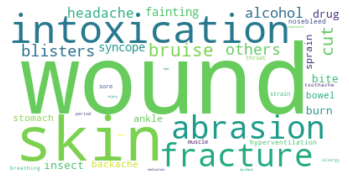

In [47]:
#Generate wordclouds of injuries at Vlasmarkt
text_wordcloud = ''
for word in dfrkvlasmarkt['Injury'].values:
    #wordsplit = re.split(' |/', word)
    wordtransl = d[word]
    text_wordcloud+=wordtransl+' '
wordcloud = WordCloud(background_color="white", collocations=False).generate(text_wordcloud.lower())
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('wordcloudvlas.png')

(-0.5, 399.5, 199.5, -0.5)

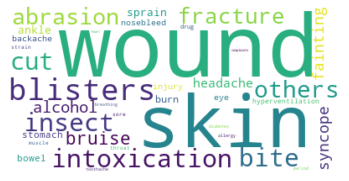

In [48]:
#Generate wordclouds of injuries at Stadshal
text_wordcloud = ''
for word in dfrkstadshal['Injury'].values:
    #wordsplit = re.split(' |/', word)
    wordtransl = d[word]
    text_wordcloud+=wordtransl+' '
wordcloud = WordCloud(background_color="white", collocations=False).generate(text_wordcloud.lower())
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('wordcloudstads.png')